In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import folium
from IPython.display import display
import datetime

/Users/pierrickgirard/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
fichier_csv_dpt_73 = os.path.join("src_data", "Q_73_previous-1950-2023_RR-T-Vent.csv")
fichier_csv_dpt_59 = os.path.join("src_data", "Q_59_previous-1950-2023_RR-T-Vent.csv")
fichier_csv_dpt_83 = os.path.join("src_data", "Q_83_previous-1950-2023_RR-T-Vent.csv")
df_dpt_73 = pd.read_csv(fichier_csv_dpt_73, sep=';', encoding='utf-8')
df_dpt_59 = pd.read_csv(fichier_csv_dpt_59, sep=';', encoding='utf-8')
df_dpt_83 = pd.read_csv(fichier_csv_dpt_83, sep=';', encoding='utf-8')

In [3]:
df_dpt_73.head()

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,73001001,AIGUEBELETTE,45.551667,5.813333,400,19510201,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73001001,AIGUEBELETTE,45.551667,5.813333,400,19510202,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,73001001,AIGUEBELETTE,45.551667,5.813333,400,19510203,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,73001001,AIGUEBELETTE,45.551667,5.813333,400,19510204,18.2,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,73001001,AIGUEBELETTE,45.551667,5.813333,400,19510205,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# ‘coerce’ => invalid parsing will be set as NaN
df_dpt_73['DATE'] = pd.to_datetime(df_dpt_73['AAAAMMJJ'], format='%Y%m%d', errors='coerce')
df_dpt_59['DATE'] = pd.to_datetime(df_dpt_59['AAAAMMJJ'], format='%Y%m%d', errors='coerce')
df_dpt_83['DATE'] = pd.to_datetime(df_dpt_83['AAAAMMJJ'], format='%Y%m%d', errors='coerce')

In [5]:
stations_from_dpt_73 = df_dpt_73.groupby(['NOM_USUEL', 'LAT', 'LON'])['DATE'].agg(['min', 'max']).reset_index()

In [6]:
# create and center the map on the first data row
m = folium.Map(location=[stations_from_dpt_73.iloc[0]['LAT'], stations_from_dpt_73.iloc[0]['LON']], zoom_start=9)
for _, row in stations_from_dpt_73.iterrows():
    folium.Marker(
        location = [row['LAT'], row['LON']],
        popup = row['NOM_USUEL'],
        tooltip = f"date_min: {row['min']} - date_max: {row['max']}"
    ).add_to(m)
display(m)

Station CHAMBERY-AIX is a good choice for the study, located between Chambéry and Aix-les-Bains and with a 50-years-history (from 1974 to 2023).
Stations ROUBAIX and CAP CAMARAT are arbitrary chosen for two other departments (one in the North, anonther in the South).

In [7]:
station_reference_dpt_73 = df_dpt_73[df_dpt_73['NOM_USUEL'] == 'CHAMBERY-AIX']
station_reference_dpt_59 = df_dpt_59[df_dpt_59['NOM_USUEL'] == 'ROUBAIX']
station_reference_dpt_83 = df_dpt_83[df_dpt_83['NOM_USUEL'] == 'CAP CAMARAT']

In order to calculate Easter dates, Butch-Meeus algorithm is used.
Cf. https://fr.wikipedia.org/wiki/Calcul_de_la_date_de_P%C3%A2ques_selon_la_m%C3%A9thode_de_Meeus

In [8]:
def algo_butcher_meeus(year):
    n = year % 19
    c = year // 100
    u = year % 100
    s = c // 4
    t = c % 4
    p = (c + 8) // 25
    q = (c - p + 1) // 3
    e = (19 * n + c - s - q + 15) % 30
    b = u // 4
    d = u % 4
    L = (2 * t + 2 * b - e - d + 32) % 7
    h = (n + 11 * e + 22 * L) // 451
    month = (e + L - 7 * h + 114) // 31
    day = ((e + L - 7 * h + 114) % 31) + 1
    return datetime.date(year, month, day)

In [9]:
# add + 1 to start_year as the first month of the first year is July (so Easter is not part of the data for the first year)
start_year = station_reference_dpt_73['DATE'].dt.year.min() + 1
end_year = station_reference_dpt_73['DATE'].dt.year.max()
years = list(range(start_year, end_year + 1))

dimanche_de_paques = [algo_butcher_meeus(year) for year in years]
set_dimanche_de_paques = set(pd.to_datetime(dimanche_de_paques))
set_lundi_de_paques = set(pd.to_datetime([date + datetime.timedelta(days=1) for date in dimanche_de_paques]))

In [10]:
# use copy() to avoid SettingWithCopyWarning 
station_reference_dpt_73_focus_on_paques = station_reference_dpt_73[station_reference_dpt_73['DATE'].isin(set_dimanche_de_paques) | station_reference_dpt_73['DATE'].isin(set_lundi_de_paques)].copy()
station_reference_dpt_59_focus_on_paques = station_reference_dpt_59[station_reference_dpt_59['DATE'].isin(set_dimanche_de_paques) | station_reference_dpt_59['DATE'].isin(set_lundi_de_paques)].copy()
station_reference_dpt_83_focus_on_paques = station_reference_dpt_83[station_reference_dpt_83['DATE'].isin(set_dimanche_de_paques) | station_reference_dpt_83['DATE'].isin(set_lundi_de_paques)].copy()

In [11]:
station_reference_dpt_73_focus_on_paques

,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR,DATE
1843654,73329001,CHAMBERY-AIX,45.641333,5.878,235,19740414,0.0,1.0,4.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974-04-14
1843655,73329001,CHAMBERY-AIX,45.641333,5.878,235,19740415,0.0,1.0,5.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1974-04-15
1844004,73329001,CHAMBERY-AIX,45.641333,5.878,235,19750330,0.0,1.0,0.1,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975-03-30
1844005,73329001,CHAMBERY-AIX,45.641333,5.878,235,19750331,1.5,1.0,-3.2,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1975-03-31
1844389,73329001,CHAMBERY-AIX,45.641333,5.878,235,19760418,0.4,1.0,2.4,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1976-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860812,73329001,CHAMBERY-AIX,45.641333,5.878,235,20210405,0.0,1.0,-1.3,1.0,...,NaN,20.7,1.0,NaN,NaN,2210.0,9.0,45.0,9.0,2021-04-05
1861189,73329001,CHAMBERY-AIX,45.641333,5.878,235,20220417,0.0,1.0,7.8,1.0,...,NaN,13.6,1.0,NaN,NaN,15.0,9.0,0.0,9.0,2022-04-17
1861190,73329001,CHAMBERY-AIX,45.641333,5.878,235,20220418,0.0,1.0,2.9,1.0,...,NaN,6.3,1.0,NaN,NaN,10.0,9.0,0.0,9.0,2022-04-18
1861546,73329001,CHAMBERY-AIX,45.641333,5.878,235,20230409,0.0,1.0,2.1,1.0,...,NaN,6.3,1.0,NaN,NaN,741.0,9.0,0.0,9.0,2023-04-09


Data is made of 100 rows so 50 weekends as Easter is a Sunday-Monday weekend.

In [12]:
station_reference_dpt_73_focus_on_paques['ANNEE'] = station_reference_dpt_73_focus_on_paques['DATE'].dt.year
station_reference_dpt_59_focus_on_paques['ANNEE'] = station_reference_dpt_59_focus_on_paques['DATE'].dt.year
station_reference_dpt_83_focus_on_paques['ANNEE'] = station_reference_dpt_83_focus_on_paques['DATE'].dt.year

station_reference_dpt_73_focus_on_paques_grouped = station_reference_dpt_73_focus_on_paques.groupby('ANNEE').agg({'RR':'sum'}).reset_index()
station_reference_dpt_59_focus_on_paques_grouped = station_reference_dpt_59_focus_on_paques.groupby('ANNEE').agg({'RR':'sum'}).reset_index()
station_reference_dpt_83_focus_on_paques_grouped = station_reference_dpt_83_focus_on_paques.groupby('ANNEE').agg({'RR':'sum'}).reset_index()

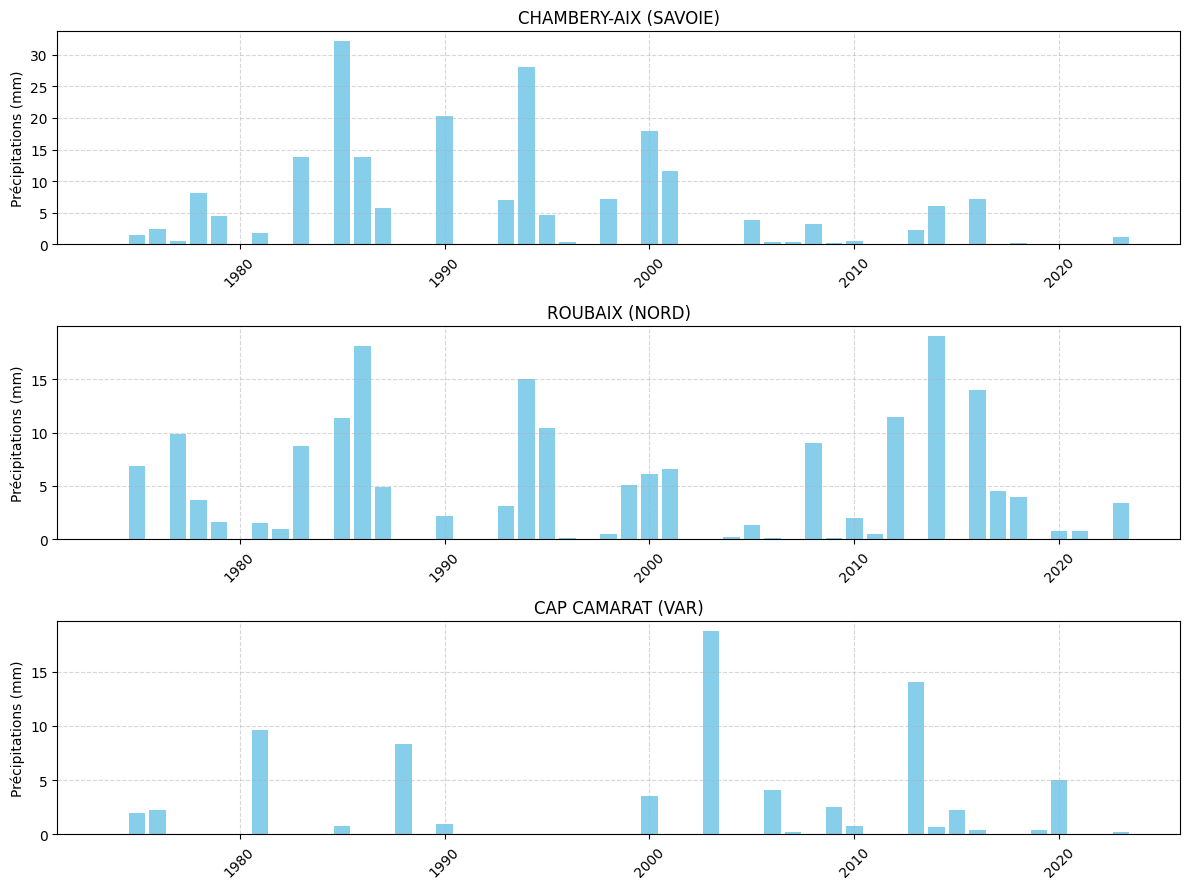

In [13]:
all_stations = [station_reference_dpt_73_focus_on_paques_grouped, station_reference_dpt_59_focus_on_paques_grouped, station_reference_dpt_83_focus_on_paques_grouped]
titles = ['CHAMBERY-AIX (SAVOIE)', 'ROUBAIX (NORD)', 'CAP CAMARAT (VAR)']

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharex=False)

for i, ax in enumerate(axes):
    ax.bar(all_stations[i]['ANNEE'], all_stations[i]['RR'], color='skyblue')
    ax.set_title(titles[i])
    ax.set_ylabel("Précipitations (mm)")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.tick_params(axis='x', rotation=45) 

plt.tight_layout()
plt.show()

In [14]:
def get_station_data(nom_station):
    if nom_station == 'CHAMBERY-AIX (SAVOIE)':
        station_data = station_reference_dpt_73_focus_on_paques_grouped
    elif nom_station == 'ROUBAIX (NORD)':
        station_data = station_reference_dpt_59_focus_on_paques_grouped
    elif nom_station == 'CAP CAMARAT (VAR)':
        station_data = station_reference_dpt_83_focus_on_paques_grouped
    else:
        return
    return station_data

In [15]:
def graphe_single_station(nom_station):
    data_frame = get_station_data(nom_station)

    plt.figure(figsize=(12, 4)) 
    
    plt.bar(
        station_reference_dpt_73_focus_on_paques_grouped['ANNEE'],
        station_reference_dpt_73_focus_on_paques_grouped['RR'],
        color='skyblue'
    )
    
    plt.title(nom_station)
    plt.xlabel('Année')
    plt.ylabel('Précipitations (mm)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

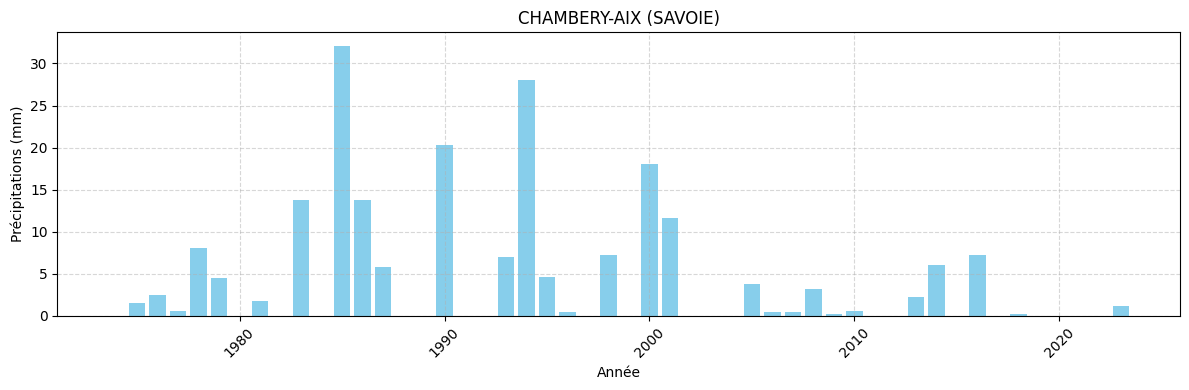

In [16]:
graphe_single_station('CHAMBERY-AIX (SAVOIE)')

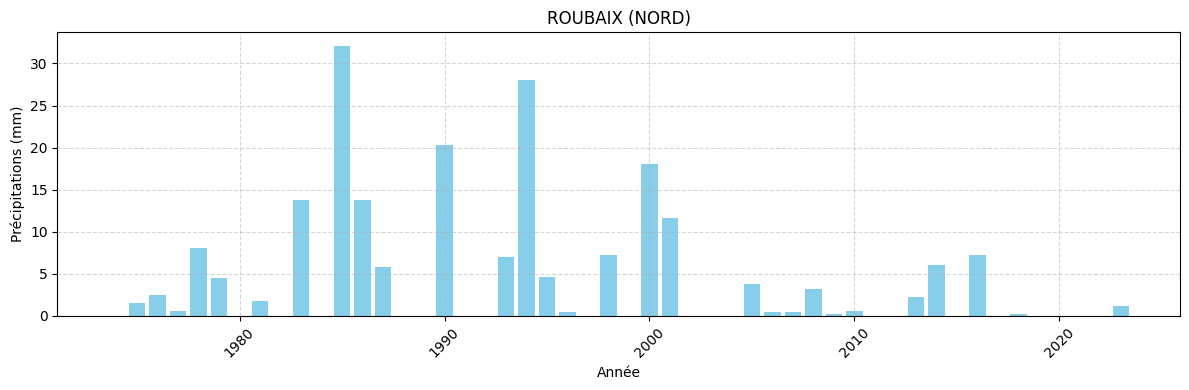

In [17]:
graphe_single_station('ROUBAIX (NORD)')

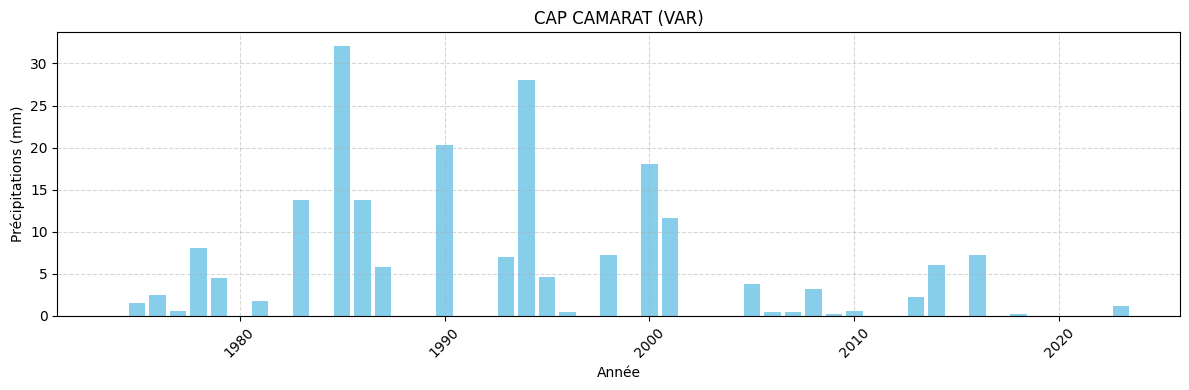

In [18]:
graphe_single_station('CAP CAMARAT (VAR)')

In [19]:
def analyse_data(nom_station):
    
    station_data = get_station_data(nom_station)

    nombre_total_de_we = station_data['RR'].count()
    nombre_we_pluvieux = (station_data[station_data['RR'] > 0]).shape[0]
    pourcentage_we_pluvieux_all_time = (nombre_we_pluvieux / nombre_total_de_we) * 100
    
    half = int(nombre_total_de_we / 2)
    first_period = station_data[:half]
    second_period = station_data[half:]
    
    nombre_we_pluvieux_first_period = int(first_period[first_period['RR'] > 0].shape[0])
    nombre_we_pluvieux_second_period = int(second_period[second_period['RR'] > 0].shape[0])
    pourcentage_we_pluvieux_first_period = (nombre_we_pluvieux_first_period / half) * 100
    pourcentage_we_pluvieux_second_period = (nombre_we_pluvieux_second_period / half) * 100
    qte_pluie_first_period = (first_period[first_period['RR'] > 0])['RR'].mean()
    qte_pluie_second_period = (second_period[second_period['RR'] > 0])['RR'].mean()

    print(f"Analyse pour la station : {nom_station}")
    print(f"Nombre de week-ends pluvieux (1974 - 2023) : {nombre_we_pluvieux} / {nombre_total_de_we}")
    print(f"Nombre de week-ends pluvieux (1974 - 1998) : {nombre_we_pluvieux_first_period} / {half}")
    print(f"Nombre de week-ends pluvieux (1999 - 2023) : {nombre_we_pluvieux_second_period} / {half}")
    print(f"Pourcentage de week-ends pluvieux (1974 - 2023) : {pourcentage_we_pluvieux_all_time:.0f} %")
    print(f"Pourcentage de week-ends pluvieux (1974 - 1998) : {pourcentage_we_pluvieux_first_period:.0f} %")
    print(f"Pourcentage de week-ends pluvieux (1999 - 2023) : {pourcentage_we_pluvieux_second_period:.0f} %")
    print(f"Quantité moyenne de pluie (1974 - 1998) : {qte_pluie_first_period:.2f} mm")
    print(f"Quantité moyenne de pluie (1999 - 2023) : {qte_pluie_second_period:.2f} mm")

In [20]:
analyse_data('CHAMBERY-AIX (SAVOIE)')

Analyse pour la station : CHAMBERY-AIX (SAVOIE)
Nombre de week-ends pluvieux (1974 - 2023) : 29 / 50
Nombre de week-ends pluvieux (1974 - 1998) : 16 / 25
Nombre de week-ends pluvieux (1999 - 2023) : 13 / 25
Pourcentage de week-ends pluvieux (1974 - 2023) : 58 %
Pourcentage de week-ends pluvieux (1974 - 1998) : 64 %
Pourcentage de week-ends pluvieux (1999 - 2023) : 52 %
Quantité moyenne de pluie (1974 - 1998) : 9.50 mm
Quantité moyenne de pluie (1999 - 2023) : 4.23 mm


In [21]:
analyse_data('ROUBAIX (NORD)')

Analyse pour la station : ROUBAIX (NORD)
Nombre de week-ends pluvieux (1974 - 2023) : 34 / 50
Nombre de week-ends pluvieux (1974 - 1998) : 16 / 25
Nombre de week-ends pluvieux (1999 - 2023) : 18 / 25
Pourcentage de week-ends pluvieux (1974 - 2023) : 68 %
Pourcentage de week-ends pluvieux (1974 - 1998) : 64 %
Pourcentage de week-ends pluvieux (1999 - 2023) : 72 %
Quantité moyenne de pluie (1974 - 1998) : 6.19 mm
Quantité moyenne de pluie (1999 - 2023) : 4.94 mm


In [22]:
analyse_data('CAP CAMARAT (VAR)')

Analyse pour la station : CAP CAMARAT (VAR)
Nombre de week-ends pluvieux (1974 - 2023) : 19 / 50
Nombre de week-ends pluvieux (1974 - 1998) : 6 / 25
Nombre de week-ends pluvieux (1999 - 2023) : 13 / 25
Pourcentage de week-ends pluvieux (1974 - 2023) : 38 %
Pourcentage de week-ends pluvieux (1974 - 1998) : 24 %
Pourcentage de week-ends pluvieux (1999 - 2023) : 52 %
Quantité moyenne de pluie (1974 - 1998) : 3.98 mm
Quantité moyenne de pluie (1999 - 2023) : 4.05 mm
